Dataset was downloaded from 
https://www.kaggle.com/hetulmehta/marvel-vs-dc-imdb-dataset

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
sns.set_theme()

In [152]:
df = pd.read_csv('Marvel_DC_imdb.csv', skipinitialspace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 14 columns):
Unnamed: 0     1690 non-null int64
Movie          1690 non-null object
Year           1657 non-null object
Genre          1683 non-null object
RunTime        1407 non-null object
Rating         1463 non-null object
Director       1474 non-null object
Actor          1660 non-null object
Description    1690 non-null object
IMDB_Score     1486 non-null float64
Metascore      65 non-null float64
Votes          1486 non-null object
USA_Gross      64 non-null object
Category       1690 non-null object
dtypes: float64(2), int64(1), object(11)
memory usage: 184.9+ KB


In [153]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [154]:
df['Movie'].value_counts().shape

(314,)

There are 314 unique entries in the Movie column; however, 1690 entries in that column. There most be lots of repeats.

In [155]:
print( df['Movie'].value_counts().head(), '\n\n',
df['Movie'].value_counts().tail() )

Smallville                176
Gotham                    101
Agents of S.H.I.E.L.D.     92
DC Super Hero Girls        91
Supergirl                  87
Name: Movie, dtype: int64 

 Guarding the Balance: Batman and the JLA                                                                        1
Joker                                                                                                           1
Revolutionizing a Classic: From Comic Book to Television - The Evolution of Wonder Woman from Page to Screen    1
The Sinister Six                                                                                                1
Batman Beyond: Return of the Joker                                                                              1
Name: Movie, dtype: int64


The Movie column contains tv shows and movies.  The tv shows are listed by episode and is inflating the total count of the Movie column.  It would be best to seperate the two.

In [156]:
df['Rating'].value_counts(dropna=False)

TV-PG        543
TV-14        333
NaN          227
TV-Y7        179
Unrated       90
TV-Y7-FV      75
Not Rated     69
PG-13         62
TV-MA         58
R             19
PG            17
T              6
TV-G           4
K-A            4
E10+           2
M              1
TV-Y           1
Name: Rating, dtype: int64

There are also video games in the list going off the rating column.  T, K-A, E10+, M are video game ratings.  While TV-PG, TV-14, TV-Y7, TV-Y7-FV, TV-MA, TV-G, and TV-Y are tv show ratings. Unrated and Not Rated could have any of the three.  I am going to seperate the data into three dataframes: movies, tv shows, and video games.  I will keep the unrated and not rated in the movie dataframe for now.

In [157]:
movie_rating = ['PG-13', 'R', 'PG', 'Unrated', 'Not Rated', np.nan]
tv_rating = ['TV-PG', 'TV-14', 'TV-Y7', 'TV-Y7-FV', 'TV-MA', 'TV-G', 'TV-Y']
game_rating = ['T','K-A','E10+','M']

movie_data = df[df['Rating'].isin(movie_rating)].copy()
tv_data = df[df['Rating'].isin(tv_rating)].copy()
game_data = df[df['Rating'].isin(game_rating)].copy()

In [158]:
movie_data['Movie'].value_counts().head()

Batman: The Animated Series    85
Batman Beyond                  52
Batman: Black and White        20
What If...?                    11
She-Hulk                       11
Name: Movie, dtype: int64

Better, but it still contains some tv show. I can filter by runtime to get the movies. I am going to clean the runtime and change it to float.  Then I am going to filter runtimes over 61 minutes.  Anything under 61 minutes should be consider a tv show.

In [159]:
movie_data.shape

(484, 13)

In [160]:
movie_data['RunTime'] = movie_data['RunTime'].str.rstrip(' min').astype('float64')
movie_data = movie_data[(movie_data['RunTime'] > 61.0) | (movie_data['RunTime'].isna())].copy()
movie_data.shape

(236, 13)

If the year contains a dash it would indicate a range like 2010-2011.  Movies only have one year, so anything with a dash should be considered a tv show.

In [161]:
movie_data['Year'] = movie_data['Year'].str.replace('[A-z\)\(]*','').str.strip()

In [162]:
movie_data.dropna(subset=['Year', 'Rating'],inplace=True)
movie_data.drop(movie_data[movie_data['Year'].str.contains('–')].index, inplace=True)

There are movies that credit DC and Marvel for using their IP.  Most of them are comedies and we can filter most of them out by only icluding the entries with Action in the Genre column.

In [163]:
movie_data = movie_data[(movie_data['Genre'].str.contains('Action')) | (movie_data['Genre'].str.contains('Crime'))].copy()

I am going to clean the USA_Gross column and change its data type so it can be compared.

In [164]:
movie_data['USA_Gross'] = movie_data['USA_Gross'].str.lstrip('$').str.rstrip('M').astype('float64')

In [165]:
movie_data[movie_data['USA_Gross'].isna()].sample(3)

,Movie,Year,Genre,RunTime,Rating,Director,Actor,Description,IMDB_Score,Metascore,Votes,USA_Gross,Category
76,The Invincible Iron Man,2007,"Animation,Action,Adventure",83.0,PG-13,"PatrickArchibald,JayOliva,FrankPaur","MarcWorden,GwendolineYeo,FredTatasciore,Rodney...",When a cocky industrialist's efforts to raise ...,5.9,NaN,"6,991",NaN,Marvel
79,Thor: Tales of Asgard,2011,"Animation,Action,Adventure",77.0,Not Rated,SamLiu,"MatthewWolf,RickGomez,TaraStrong,AlistairAbell",The young Norse god Thor embarks on a quest wi...,6.3,NaN,"5,158",NaN,Marvel
505,Robotech: The Shadow Chronicles,2006,"Animation,Action,Adventure",88.0,PG,"Dong-WookLee,TommyYune","RichardEpcar,EddieFrierson,MarkHamill,Alexandr...","Picking up where the original series left off,...",6.5,NaN,"1,499",NaN,DC


Missing Gross data is from recent or future movies and from animated movies that didn't get released in theaters.  Most of the animated and recent movies have imdb and metascore values so I will keep them. But I think the data should also be analyzed excluding animated films to see the difference.  

In [166]:
movie_data[movie_data['Year'] == '2021']

,Movie,Year,Genre,RunTime,Rating,Director,Actor,Description,IMDB_Score,Metascore,Votes,USA_Gross,Category
5,Black Widow,2021,"Action,Adventure,Sci-Fi",133.0,PG-13,CateShortland,"ScarlettJohansson,FlorencePugh,DavidHarbour,Ra...",A film about Natasha Romanoff in her quests be...,NaN,NaN,NaN,NaN,Marvel
390,The Suicide Squad,2021,"Action,Adventure,Comedy",NaN,R,JamesGunn,"MargotRobbie,IdrisElba,JohnCena,TaikaWaititi","Supervillains Harley Quinn, Bloodsport, Peacem...",NaN,NaN,NaN,NaN,DC
419,Justice Society: World War II,2021,"Animation,Action,Adventure",84.0,PG-13,JeffWamester,"StanaKatic,MattBomer,OmidAbtahi,GeoffreyArend","The Justice Society of America, a group of her...",6.4,NaN,"3,430",NaN,DC
422,"Batman: The Long Halloween, Part One",2021,"Animation,Action,Crime",NaN,PG-13,ChrisPalmer,"JoshDuhamel,JackQuaid,JensenAckles,AlyssaDiaz",Batman investigates a murder spree that takes ...,NaN,NaN,NaN,NaN,DC
442,Batman: Soul of the Dragon,2021,"Animation,Action,Adventure",83.0,R,SamLiu,"DavidGiuntoli,MarkDacascos,KellyHu,MichaelJaiW...","In the 1970s, a missing teacher of martial art...",6.1,NaN,"3,373",NaN,DC


Black Widow, The Suicide Squad and Batman the Long Halloween haven't been released yet so they will get dropped.

In [167]:
movie_data.drop([5,390,422,580,407], axis=0, inplace=True)

In [168]:
movie_data.drop(movie_data[movie_data['Movie'] == 'Galaxian'].index, inplace=True) 
# A game that didn't get filtered

In [169]:
movie_data.drop(movie_data[(movie_data['Movie'] == 'Blankman') | (movie_data['Movie'] == 'Agent Cody Banks') | (movie_data['Movie'] == 'The Karate Kid') | (movie_data['Movie'] == 'I Am Legend') | (movie_data['Movie'] == 'V for Vendetta')].index, inplace=True)
# Three action movies that didn't get filtered

In [170]:
movie_data['Votes'] = movie_data['Votes'].str.replace(',','').astype('int64')
#movie_data['Year'] = pd.to_datetime(movie_data['Year'], format='%Y') # Need to fix this

In [171]:
movie_data_without_ani = movie_data.drop(movie_data[movie_data['Genre'].str.contains('Animation')].index)

The movie data has been cleaned and is ready to be analyzed.

In [172]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 6 to 505
Data columns (total 13 columns):
Movie          78 non-null object
Year           78 non-null object
Genre          78 non-null object
RunTime        78 non-null float64
Rating         78 non-null object
Director       78 non-null object
Actor          78 non-null object
Description    78 non-null object
IMDB_Score     78 non-null float64
Metascore      51 non-null float64
Votes          78 non-null int64
USA_Gross      51 non-null float64
Category       78 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 11.0+ KB


In [173]:
movie_data_without_ani.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 6 to 437
Data columns (total 13 columns):
Movie          49 non-null object
Year           49 non-null object
Genre          49 non-null object
RunTime        49 non-null float64
Rating         49 non-null object
Director       49 non-null object
Actor          49 non-null object
Description    49 non-null object
IMDB_Score     49 non-null float64
Metascore      49 non-null float64
Votes          49 non-null int64
USA_Gross      49 non-null float64
Category       49 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 5.4+ KB


In [174]:
movie_data.groupby('Category').count()

,Movie,Year,Genre,RunTime,Rating,Director,Actor,Description,IMDB_Score,Metascore,Votes,USA_Gross
Category,,,,,,,,,,,,
DC,46,46,46,46,46,46,46,46,46,25,46,25
Marvel,32,32,32,32,32,32,32,32,32,26,32,26


In [175]:
movie_data_without_ani.groupby('Category').count()

,Movie,Year,Genre,RunTime,Rating,Director,Actor,Description,IMDB_Score,Metascore,Votes,USA_Gross
Category,,,,,,,,,,,,
DC,23,23,23,23,23,23,23,23,23,23,23,23
Marvel,26,26,26,26,26,26,26,26,26,26,26,26


In [176]:
movie_data.to_csv('Marvel_DC_Movies_Clean.csv')

In [177]:
movie_data_without_ani.sort_values('USA_Gross', ascending=False, inplace=True)

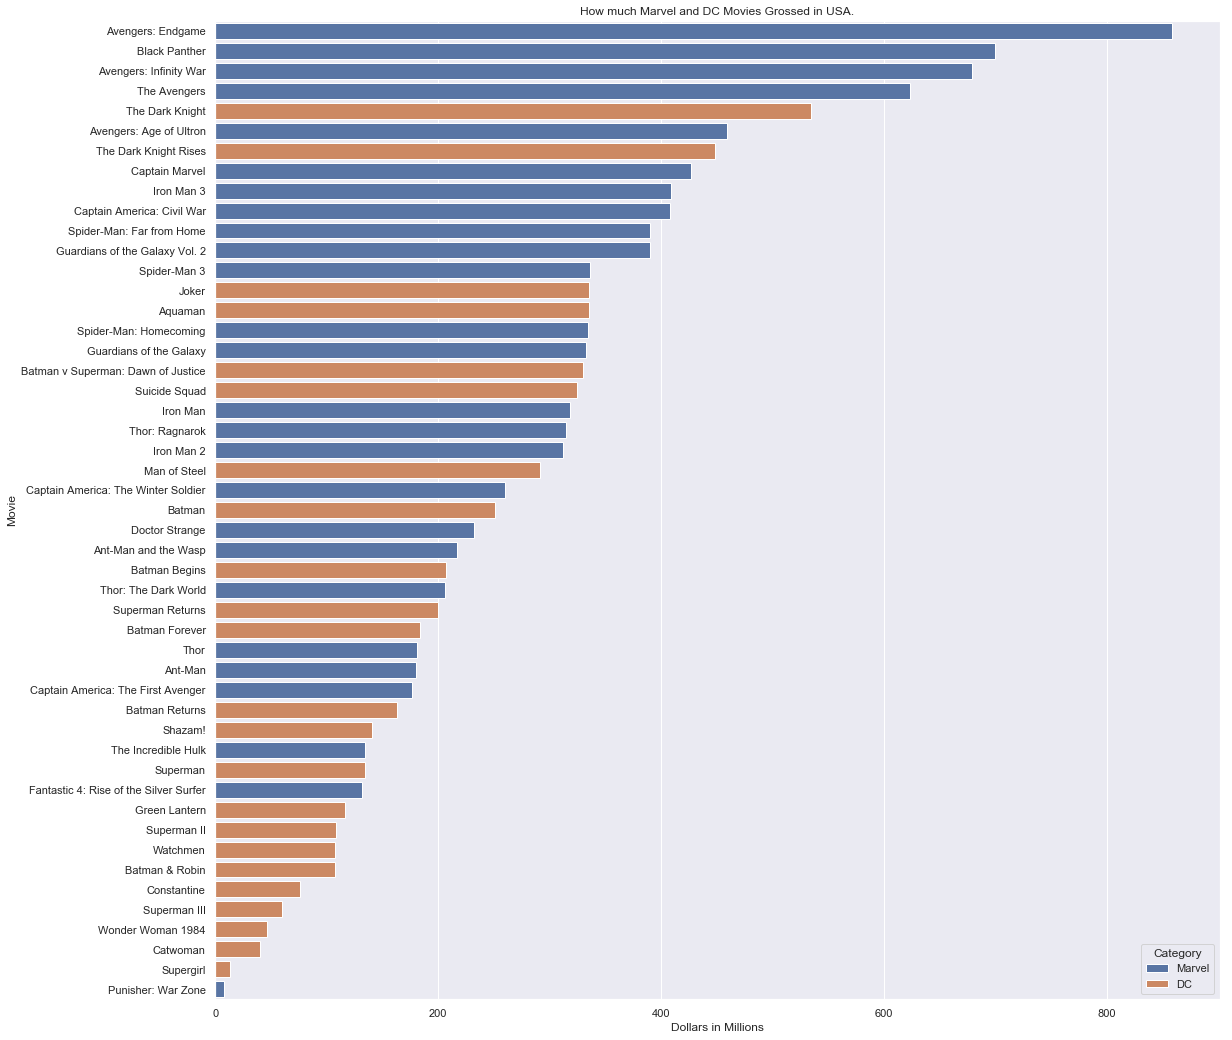

In [179]:
plt.figure(figsize = (18,18))
sns.barplot(x = 'USA_Gross', y = 'Movie',hue ='Category', data = movie_data_without_ani, dodge=False).set_title('How much Marvel and DC Movies Grossed in USA.')
plt.xlabel('Dollars in Millions')
plt.show()

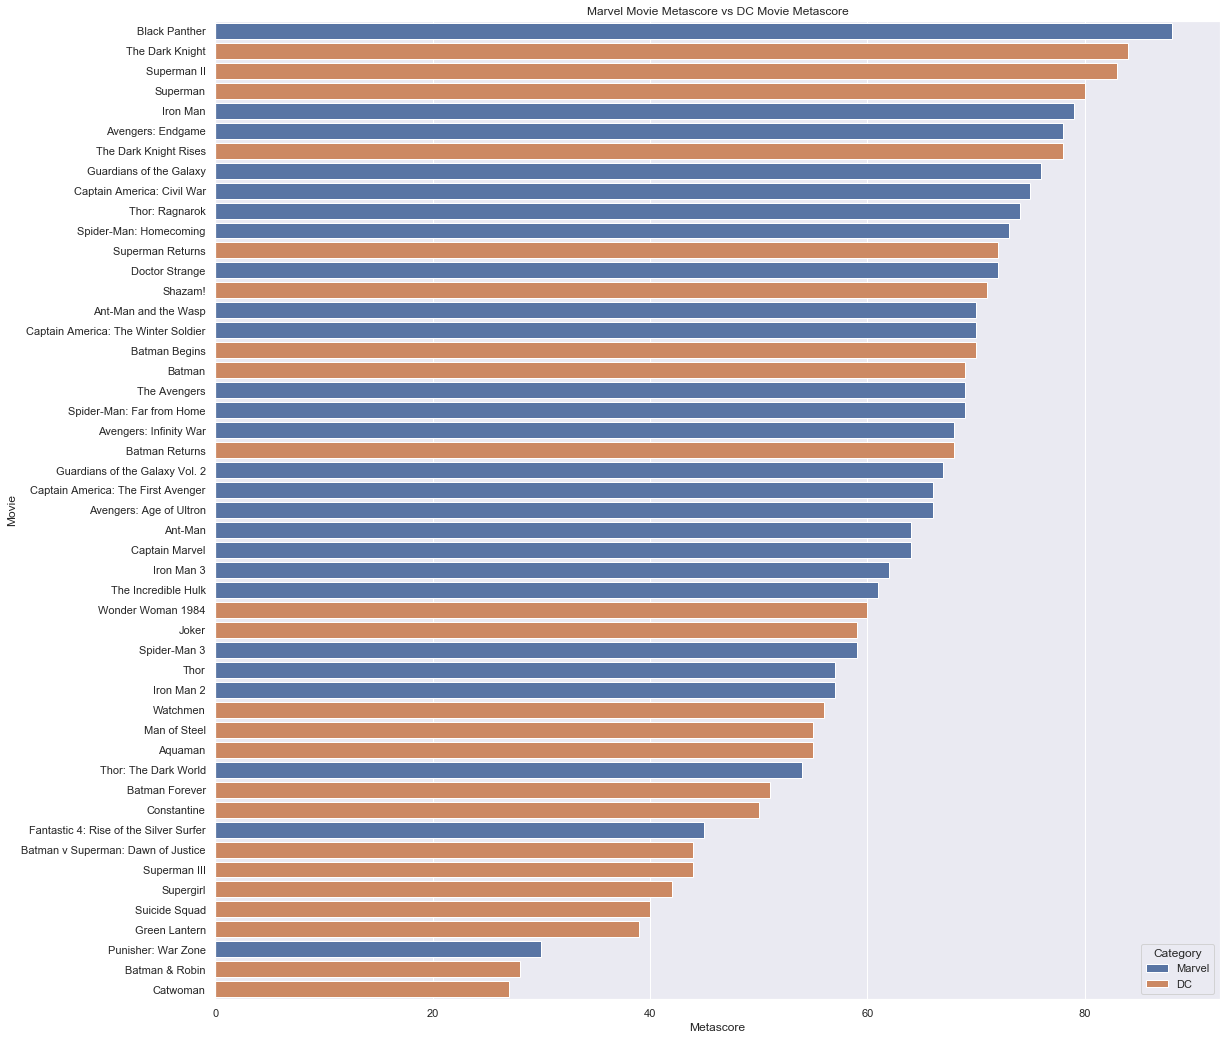

In [180]:
movie_data_without_ani.sort_values('Metascore', ascending=False, inplace=True)

plt.figure(figsize = (18,18))
sns.barplot(x = 'Metascore', y = 'Movie',hue ='Category', data = movie_data_without_ani, dodge=False).set_title('Marvel Movie Metascore vs DC Movie Metascore')
plt.show()

This section will clean the tv show data

In [ ]:
tv_data.info()

I will drop USA Gross and MetaScore since those columns have no values. I will also change Runtime and Votes to int data types.

In [ ]:
tv_data.drop(['Metascore','USA_Gross'],axis=1,inplace=True)

In [ ]:
tv_data['RunTime'] = tv_data['RunTime'].str.rstrip(' min').astype('float64')
tv_data['Votes'] = tv_data['Votes'].str.replace(',','').astype('int64', errors='ignore')
tv_data['Year'] = tv_data['Year'].str.replace('[A-z\)\(]*','').str.strip()

Any range in the year column will be split into two columns: a start year and end year. If there is no end year it will be na

In [ ]:
tv_data[['Start_Year', 'End_Year']] = tv_data['Year'].str.split('–', expand=True)
tv_data['Start_Year'].fillna(value=np.nan, inplace=True)
tv_data['End_Year'].fillna(value=np.nan, inplace=True)
tv_data['End_Year'] = tv_data['End_Year'].replace(r'^\s*$', np.nan, regex=True)

In [ ]:
tv_data.to_csv('Marvel_DC_TV_Clean.csv')

In [ ]:
tv_data.info()

In [ ]:
df[df['Movie'].str.contains('Steel')]